In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import ks_2samp
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

sns.set_theme(style="whitegrid")

In [2]:
real_df = pd.read_csv("../data/telemetry.csv").drop(columns=["User ID"], errors="ignore")
synthetic_df = pd.read_csv("../data/synthetic.csv")

for dataframe in [real_df, synthetic_df]:
    dataframe["TimeSeconds"] = pd.to_datetime(dataframe["Time of Event"]).astype("int64") // 1_000_000_000

In [3]:
summary = pd.DataFrame({"dataset": ["real", "synthetic"], "rows": [len(real_df), len(synthetic_df)]})
display(summary.style.hide(axis="index").format({"rows": "{:,}"}))

dataset,rows
real,"152,356"
synthetic,"10,000"


category,real,synthetic,absolute_delta,relative_delta_%
A,0.151592,0.152500,0.0009,0.09
B,0.251549,0.291000,0.0395,3.95
C,0.186865,0.197100,0.0102,1.02
D,0.200393,0.228700,0.0283,2.83
E,0.010377,0.000100,0.0103,1.03
F,0.098874,0.045900,0.0530,5.30
Others,0.100350,0.084700,0.0157,1.57


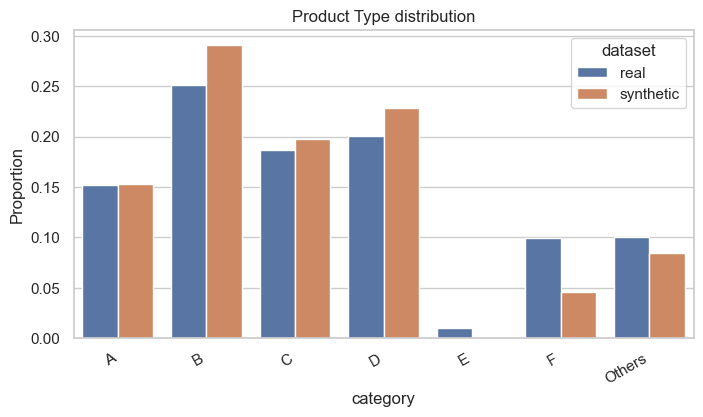

category,real,synthetic,absolute_delta,relative_delta_%
close,0.307733,0.381300,0.0736,7.36
error,0.032326,0.010700,0.0216,2.16
open,0.382696,0.426900,0.0442,4.42
reset,0.067454,0.018000,0.0495,4.95
save,0.209792,0.163100,0.0467,4.67


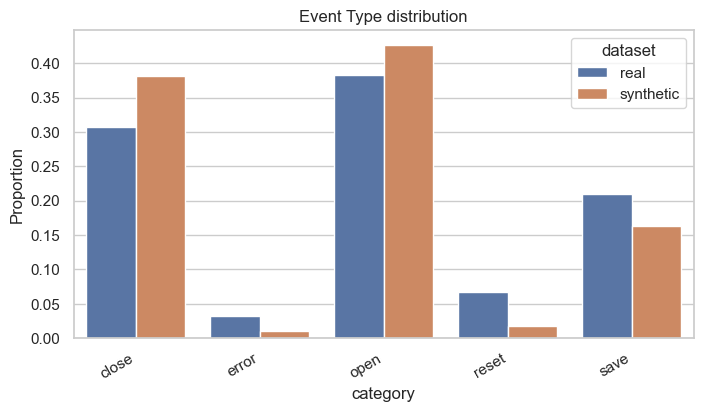

In [4]:
def compare_categorical(column):
    real = real_df[column].value_counts(normalize=True).sort_index()
    synthetic = synthetic_df[column].value_counts(normalize=True).sort_index()
    comparison = pd.concat([real, synthetic], axis=1).fillna(0)
    comparison.columns = ["real", "synthetic"]
    comparison["absolute_delta"] = (comparison["synthetic"] - comparison["real"]).abs()
    comparison["relative_delta_%"] = comparison["absolute_delta"] * 100
    return comparison.reset_index().rename(columns={comparison.index.name or "index": "category"})

for column in ["Product Type", "Event Type"]:
    table = compare_categorical(column)
    display(table.style.hide(axis="index").format({"absolute_delta": "{:.4f}", "relative_delta_%": "{:.2f}"}))
    
    melted = table[["category", "real", "synthetic"]].melt(id_vars="category", var_name="dataset", value_name="proportion")
    plt.figure(figsize=(8, 4))
    sns.barplot(data=melted, x="category", y="proportion", hue="dataset")
    plt.title(f"{column} distribution")
    plt.ylabel("Proportion")
    plt.xticks(rotation=30, ha="right")
    plt.show()

In [5]:
statistic, pvalue = ks_2samp(real_df["TimeSeconds"], synthetic_df["TimeSeconds"])

statistics = real_df["TimeSeconds"].describe()[["mean", "std", "min", "max"]]
numeric_summary = pd.DataFrame({
    "metric": ["mean", "std", "min", "max"],
    "real": statistics.values,
    "synthetic": synthetic_df["TimeSeconds"].describe()[["mean", "std", "min", "max"]].values
})
display(numeric_summary.style.hide(axis="index").format({"real": "{:.2f}", "synthetic": "{:.2f}"}))

test_results = pd.DataFrame({"statistic": [statistic], "p_value": [pvalue]})
display(test_results.style.hide(axis="index").format({"statistic": "{:.3f}", "p_value": "{:.2e}"}))

metric,real,synthetic
mean,1718462125.60,1718434451.10
std,2265577.72,1646876.40
min,1714521637.00,1714521637.00
max,1722383984.00,1722383984.00


statistic,p_value
0.137,6.16e-154


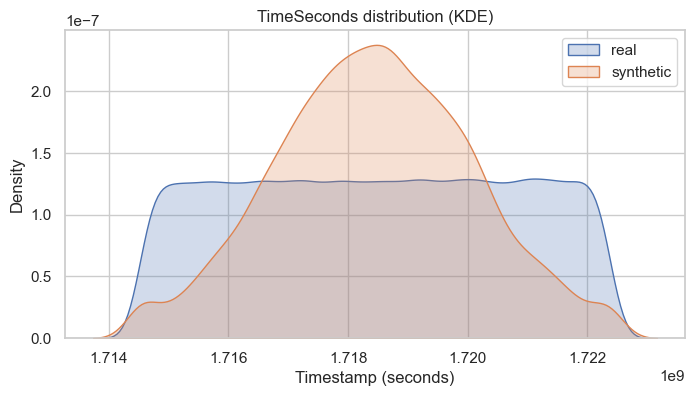

In [6]:
plt.figure(figsize=(8, 4))
for dataframe, label in [(real_df, "real"), (synthetic_df, "synthetic")]:
    sns.kdeplot(dataframe["TimeSeconds"], label=label, fill=True)
plt.title("TimeSeconds distribution (KDE)")
plt.xlabel("Timestamp (seconds)")
plt.legend()
plt.show()

In [7]:
def prepare_features(dataframe, transformer=None):
    features, target = dataframe[["Product Type", "TimeSeconds"]], dataframe["Event Type"]
    if transformer is None:
        transformer = ColumnTransformer([
            ("product", OneHotEncoder(handle_unknown="ignore"), ["Product Type"]),
            ("time", StandardScaler(), ["TimeSeconds"])
        ])
        return transformer.fit_transform(features), target, transformer
    return transformer.transform(features), target, transformer

def evaluate_training(training, testing):
    X_train, y_train, transformer = prepare_features(training)
    X_test, y_test, _ = prepare_features(testing, transformer)
    
    model = LogisticRegression(max_iter=1000).fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    return {
        "accuracy": accuracy_score(y_test, predictions),
        "report": pd.DataFrame(classification_report(y_test, predictions, zero_division=0, output_dict=True)).T
    }

real_train, real_test = train_test_split(real_df, test_size=0.3, random_state=42)
results = {
    "synthetic_training": evaluate_training(synthetic_df, real_df),
    "baseline": evaluate_training(real_train, real_test)
}

In [8]:
accuracy_df = pd.DataFrame({
    "scenario": list(results.keys()),
    "accuracy": [outcome["accuracy"] for outcome in results.values()]
})
display(accuracy_df.style.hide(axis="index").format({"accuracy": "{:.3f}"}))

scenario,accuracy
synthetic_training,0.380
baseline,0.381


In [9]:
combined_classification = pd.concat({scenario: result["report"] for scenario, result in results.items()}, axis=1)
combined_classification.index.name = "class"
display(combined_classification.style.hide(axis="index").format({column: "{:.3f}" for column in combined_classification.columns}))